In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras import layers

In [2]:

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Project_intern/Fraud.csv")


In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df = data.copy()
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Data set contains 'int64' & 'object' & 'float64' types of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# No null values present within the data set
df.isnull().sum().sum()

0

In [7]:
#we have all 0s & 1s in our Target Feature and its a binary classification problem
df['isFraud'].unique()

array([0, 1])

In [8]:
# checking whether the data is balanced or not.
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [9]:
df.shape

(6362620, 11)

In [10]:
# non fradulent transactions are

100*(6354407/6362620)

99.87091795518198

In [11]:
df['type'].value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


**1. Data cleaning including missing values, outliers and multi-collinearity**

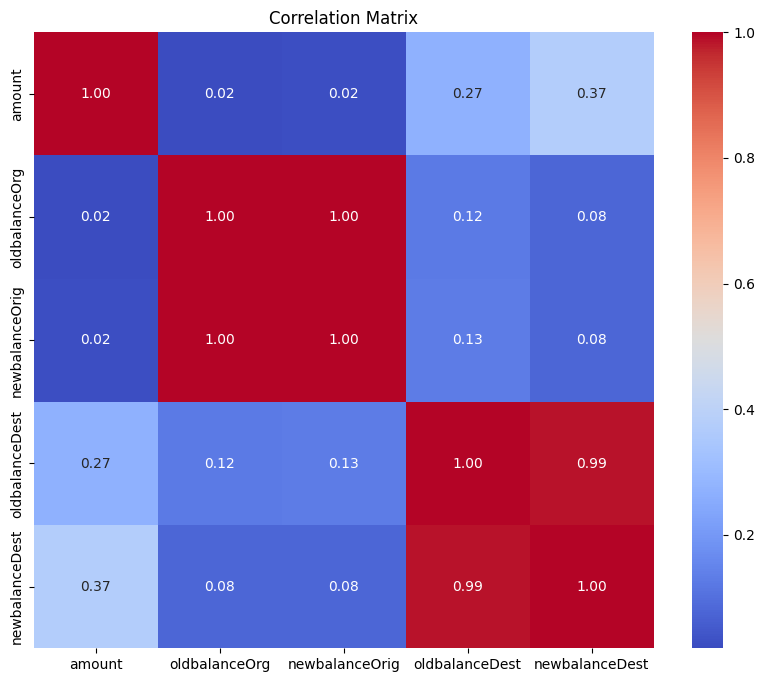

In [12]:
from scipy import stats  # Ensure this import is included
# Handle missing values
df['amount'].fillna(df['amount'].median(), inplace=True)
df['nameOrig'].fillna('Unknown', inplace=True)

# Detect and handle outliers
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
z_scores = np.abs(stats.zscore(df[numeric_columns]))
df_outliers = pd.DataFrame(z_scores, columns=numeric_columns)
outliers = (df_outliers > 3).any(axis=1)
df_clean = df[~outliers]

# Check for multi-collinearity
corr = df_clean[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

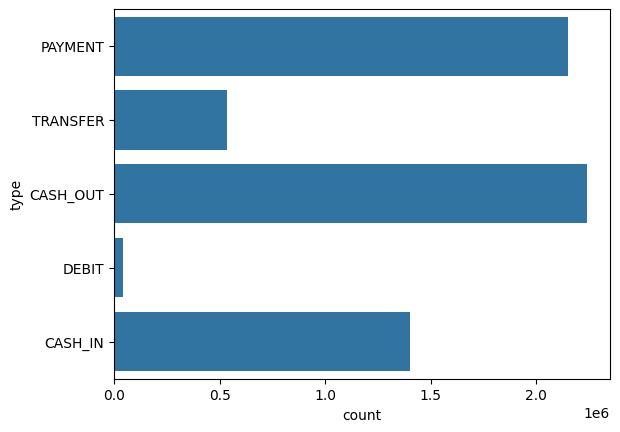

In [13]:
sns.countplot(df['type'])
plt.show()

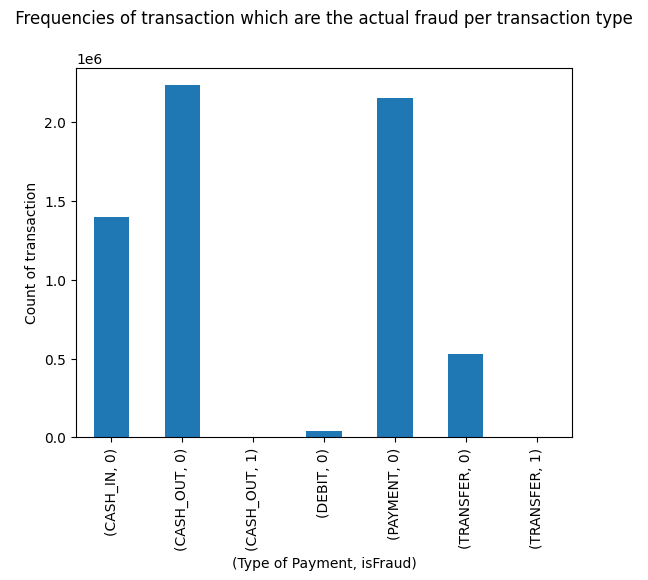

In [14]:
fraud_type = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
fraud_type.set_title(" Frequencies of transaction which are the actual fraud per transaction type \n" )
fraud_type.set_xlabel("(Type of Payment, isFraud)")
fraud_type.set_ylabel("Count of transaction")

plt.show()

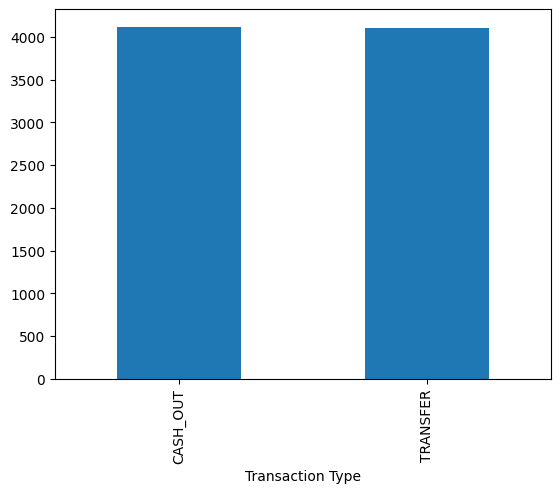

In [15]:
fraud = df['isFraud'].isin([1])

fraud_time = df[fraud].groupby(['type']).size().plot(kind='bar')
fraud_time.set_xlabel("Transaction Type")

plt.show()

**2. Describe your fraud detection model in elaboration.**

**1. Objective of the Fraud Detection Model**

The goal of a fraud detection model is to identify potentially fraudulent transactions within a dataset of transactions. The model aims to minimize false positives (legitimate transactions flagged as fraudulent) and false negatives (fraudulent transactions not detected).

**2. Dataset Description**

Typically, the dataset for fraud detection includes the following features:

**Transaction details:** Amount, type of transaction (e.g., CASH_IN, CASH_OUT, TRANSFER), timestamp, etc.
Account information: Account IDs (e.g., nameOrig, nameDest), balances before and after transactions.

**Fraud indicators:** Labels indicating whether a transaction is fraudulent (isFraud) or flagged as potentially fraudulent (isFlaggedFraud).

**3. Data Preprocessing**

**a. Handling Missing Values:**

Imputation: Fill missing values with statistical measures (mean, median) or use advanced imputation techniques based on the data.

**b. Encoding Categorical Variables:**

Convert categorical variables (e.g., type) into numerical format using one-hot encoding or label encoding.

**c. Outlier Detection:**

Use methods like the IQR (Interquartile Range) to detect and handle outliers in numerical features.

**4. Feature Selection**

Select the most relevant features for model training to improve performance and reduce computational complexity. Techniques include:

**Correlation Analysis:** Remove highly correlated features.

**Feature Importance:** Use algorithms like Random Forest or Gradient Boosting to evaluate feature importance.

**5. Model Selection**

Several machine learning models can be used for fraud detection, including:

a. Logistic Regression:

Simple model for binary classification that outputs probabilities.

b. Decision Trees and Random Forests:

Trees that split data based on feature values, with Random Forests combining multiple trees to improve performance.

6. Model Training and Evaluation

a. Training:

Split the dataset into training and validation sets.
Train the model using the training set and optimize hyperparameters.

b. Evaluation Metrics:

Accuracy: Overall correctness of the model.

Precision: Proportion of true positives among predicted positives.

Recall: Proportion of true positives among actual positives.

F1 Score: Harmonic mean of precision and recall.

ROC-AUC: Area under the ROC curve to measure the trade-off between true positive rate and false positive rate.


In [16]:

# Encode categorical variables
label_encoders = {}
for column in ['type', 'nameOrig', 'nameDest']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


**3. How did you select variables to be included in the model?**


Selecting variables (or features) to include in a model is a critical step in building a machine learning model. The process involves understanding which variables contribute to predicting the target variable effectively and ensuring the model is both accurate and efficient.

# **Model**

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")


Confusion Matrix:
[[1906252      99]
 [   1395    1040]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.91      0.43      0.58      2435

    accuracy                           1.00   1908786
   macro avg       0.96      0.71      0.79   1908786
weighted avg       1.00      1.00      1.00   1908786


ROC-AUC Score: 0.97


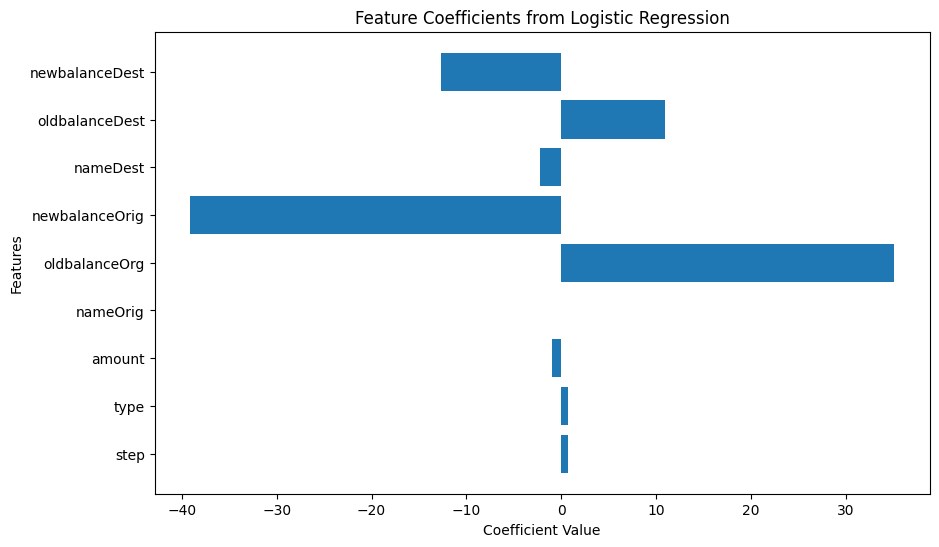

In [20]:
# Get feature importance (coefficients in this case)
feature_importances = model.coef_[0]
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Coefficients from Logistic Regression')
plt.show()

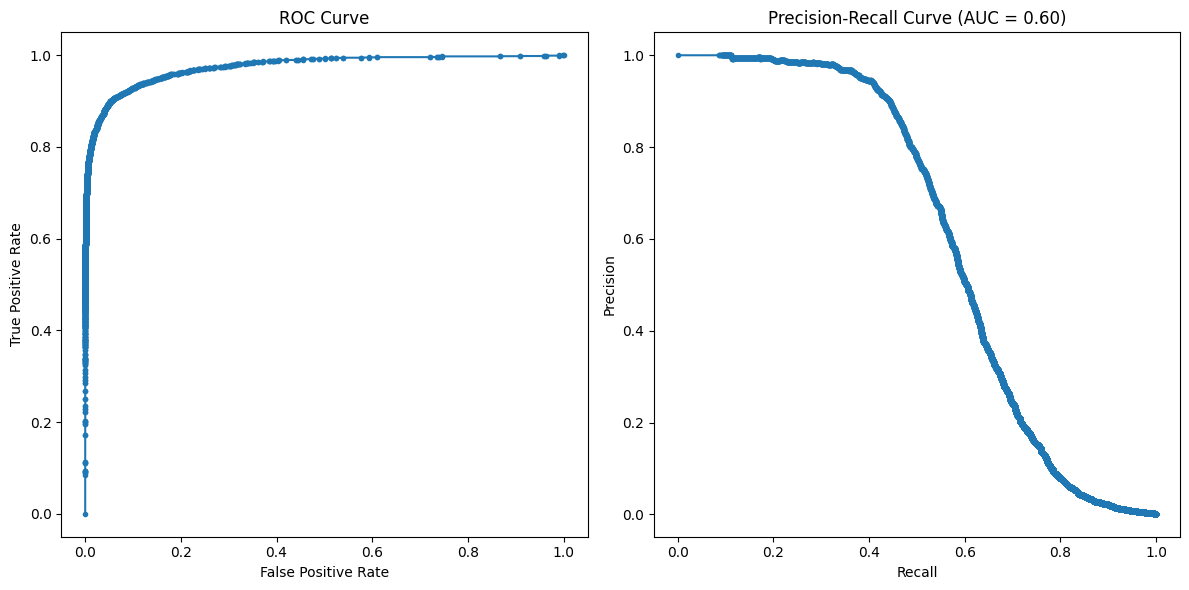

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
 #Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
# Calculate the area under the curve (AUC)
pr_auc = auc(recall, precision)

plt.figure(figsize=(12, 6))

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(pr_auc))

plt.tight_layout()
plt.show()

**7. What kind of prevention should be adopted while company update its infrastructure?**

**1. Risk Assessment and Planning**

Conduct a Risk Assessment:

Identify Vulnerabilities: Assess potential risks associated with the new infrastructure, including security vulnerabilities, compatibility issues, and operational impacts.
Impact Analysis: Understand how the update might affect different aspects of the business, including data integrity, system availability, and user access.

Develop a Detailed Plan:

Update Strategy: Create a clear and detailed plan outlining the update process, including timelines, resources, and responsible teams.
Rollback Plan: Develop a rollback or contingency plan in case the update encounters issues or fails.

**2. Security Measures**

Perform Security Audits:

Vulnerability Scanning: Conduct vulnerability scans on the new infrastructure to identify potential security issues before they are exploited.

Penetration Testing: Engage in penetration testing to evaluate the security of the updated infrastructure.
Implement Access Controls:

Role-Based Access: Ensure that only authorized personnel have access to critical systems and data.

Authentication Mechanisms: Use multi-factor authentication (MFA) to enhance security for accessing infrastructure components.

Secure Data Transmission:

Encryption: Implement encryption for data in transit and at rest to protect sensitive information.


**3. Testing and Validation**

Conduct Thorough Testing:

Unit Testing: Test individual components and functionalities to ensure they work as expected.

Integration Testing: Test how new components interact with existing systems to ensure compatibility.

Performance Testing: Evaluate system performance under load to identify potential bottlenecks or issues.

Perform User Acceptance Testing (UAT):

End-User Feedback: Allow end-users to test the new infrastructure in a controlled environment to ensure it meets their needs and functions correctly.

**4. Data Protection and Backup**

Ensure Data Integrity:

Data Backup: Create comprehensive backups of all critical data before making changes. Ensure backups are stored securely and tested for reliability.

Data Migration: Carefully plan and execute data migration to prevent data loss or corruption.

Monitor Data Integrity:

Integrity Checks: Implement checks to verify that data remains accurate and intact during and after the update.


**5. Communication and Training**

Communicate with Stakeholders:

Notify Users: Inform employees, customers, and other stakeholders about upcoming changes and any potential impact.

Provide Updates: Keep stakeholders updated on the progress of the update and any issues encountered.

Train Personnel:

Training Programs: Provide training for staff on new systems, processes, or tools introduced as part of the update.

Documentation: Ensure comprehensive documentation is available to assist with troubleshooting and support.

**6. Monitoring and Incident Response**

Monitor Systems Post-Update:

Performance Monitoring: Continuously monitor system performance and stability after the update to quickly identify and address any issues.

Security Monitoring: Implement real-time security monitoring to detect and respond to any potential security threats.

Prepare for Incident Response:

Incident Response Plan: Have an incident response plan in place to quickly address any problems or breaches that arise after the update.

Post-Mortem Analysis: Conduct a post-update review to assess what went well and what could be improved for future updates.

**7. Compliance and Documentation**

Ensure Compliance:

Regulatory Requirements: Verify that the updated infrastructure complies with relevant regulatory and industry standards.

Audit Trails: Maintain detailed records of the update process, including changes made and any issues encountered.

Update Documentation:

System Documentation: Update system documentation to reflect changes and provide guidance for future maintenance.

**8. Change Management**

Implement Change Management Processes:

Controlled Changes: Apply changes in a controlled manner, following established change management procedures.

Approval Processes: Ensure that changes are reviewed and approved by relevant stakeholders before implementation.

   ** **

**8. Assuming these actions have been implemented, how would you determine if they work?**

**1. Post-Implementation Monitoring**

a. System Performance Monitoring:

* Performance Metrics: Track key performance indicators (KPIs) such as system response times, load handling, and transaction processing speeds. Ensure that performance meets or exceeds the expectations set during planning.

* Error Logs: Monitor system logs for errors, warnings, or unexpected behaviors that might indicate issues with the update.

b. Security Monitoring:

* Intrusion Detection: Use intrusion detection systems (IDS) and security information and event management (SIEM) tools to detect any unauthorized access or security breaches.

* Vulnerability Scanning: Regularly scan the updated infrastructure for new vulnerabilities that could have been introduced.

**2. Testing and Validation**

a. Functionality Testing:

* Automated Tests: Run automated test suites to verify that all functionalities work as intended. This includes unit tests, integration tests, and regression tests.

* User Acceptance Testing (UAT): Collect feedback from end-users who are using the new infrastructure. Ensure that the system meets their needs and performs as expected.

b. Performance Testing:

* Load Testing: Conduct load testing to simulate real-world usage and ensure the system can handle the expected load without performance degradation.

* Stress Testing: Evaluate how the system performs under extreme conditions to identify any potential weaknesses.

**3. Feedback Collection**

a. Stakeholder Feedback:

* User Surveys: Distribute surveys to users to gather their feedback on the new infrastructure. Look for feedback on usability, performance, and any issues they may have encountered.

* Help Desk Reports: Analyze help desk and support tickets to identify recurring problems or user concerns related to the update.

b. Internal Reviews:

* Post-Mortem Analysis: Conduct a post-mortem review involving key stakeholders to assess what went well, what issues were encountered, and how they were resolved.

* Change Review Meetings: Hold meetings with teams involved in the update to discuss any challenges faced and the effectiveness of the preventive measures.

**4. Data Protection and Backup Validation**

a. Backup Verification:

* Backup Integrity: Test backups to ensure they are complete and can be restored successfully. This confirms that data protection measures are working as intended.

* Data Migration Validation: Verify that data migrated during the update is accurate and complete.

b. Integrity Checks:

Data Consistency: Perform checks to ensure that data remains consistent and accurate after the update.

**5. Compliance and Documentation Review**

a. Compliance Checks:

* Regulatory Compliance: Review whether the updated infrastructure continues to comply with relevant regulatory and industry standards. This may involve audits or assessments by external or internal auditors.

* Documentation Accuracy: Ensure that system documentation reflects the new infrastructure accurately and is up-to-date.

b. Documentation Feedback:

* User Manuals and Guides: Confirm that updated documentation is useful and accurate by soliciting feedback from users and support teams.

**6. Incident Response Evaluation**

a. Incident Analysis:

* Incident Response Effectiveness: Review how effectively the incident response plan was executed during any issues or breaches. Analyze the response times, actions taken, and resolution effectiveness.

Lessons Learned: Document lessons learned from any incidents to improve future updates and response strategies.

b. Post-Update Review:

* Review Findings: Assess findings from the incident response to determine if any gaps or improvements are needed in the preventive measures.

**7. Continuous Improvement**

a. Iterative Improvements:

* Ongoing Adjustments: Based on the feedback and monitoring results, make iterative improvements to the infrastructure and preventive measures.

* Update Procedures: Refine update procedures and preventive measures based on lessons learned and evolving best practices.

b. Regular Reviews:

* Scheduled Reviews: Conduct regular reviews of the infrastructure and preventive measures to ensure continued effectiveness and alignment with business needs.

# **ANN Model for Fraud Detection**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
5939/5939 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9988 - loss: 0.0231 - val_accuracy: 0.9992 - val_loss: 0.0045
Epoch 2/5
5939/5939 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9992 - loss: 0.0038 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 3/5
5939/5939 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 4/5
5939/5939 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 5/5
5939/5939 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9995 - val_loss: 0.0026
59650/59650 ━━━━━━━━━━━━━━━━━━━━ 200s 3ms/step
59650/59650 ━━━━━━━━━━━━━━━━━━━━ 108s 2ms/step
Confusion Matrix:
[[1906293      58]
 [    979    1456]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.96      0.60      0.74      2435

    accurac

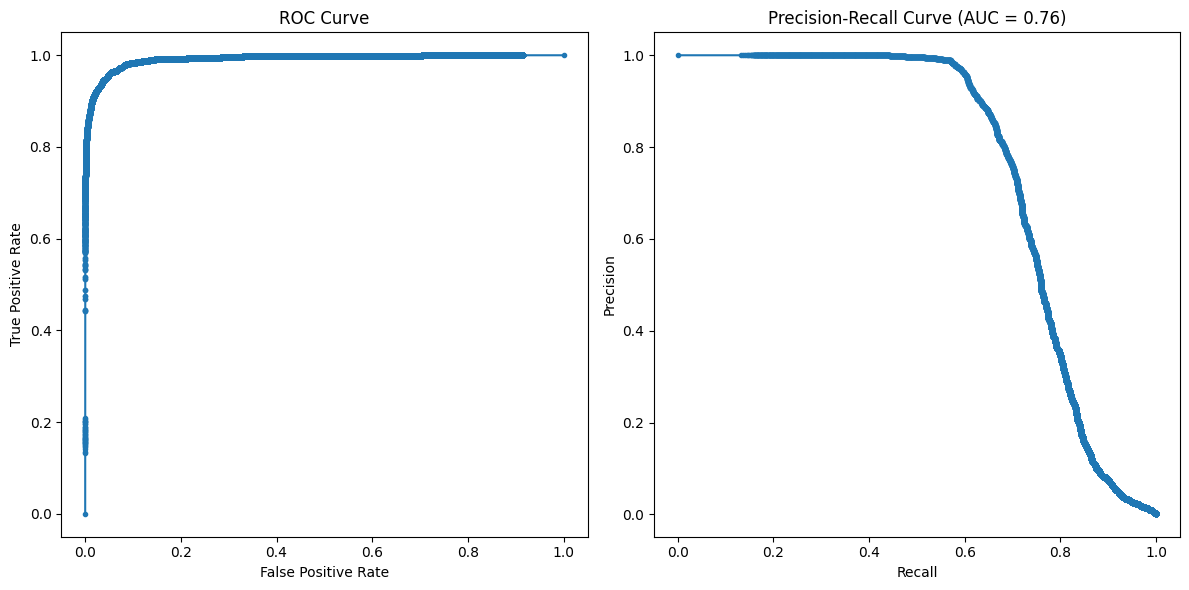

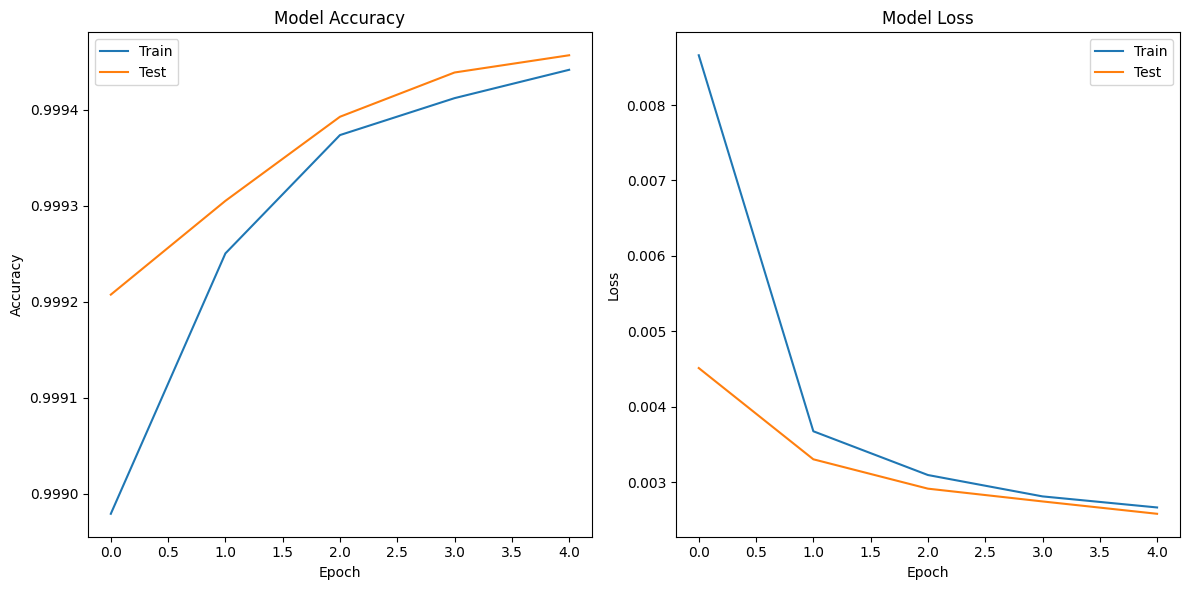

In [55]:
# Encode categorical variables
label_encoders = {}
for column in ['type', 'nameOrig', 'nameDest']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the simplified ANN model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))  # Fewer units
model.add(Dense(units=16, activation='relu'))  # Fewer units
model.add(Dense(units=1, activation='sigmoid'))  # Output layer with sigmoid activation

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with reduced epochs and batch size
history = model.fit(X_train, y_train, epochs=5, batch_size=600, validation_split=0.2, verbose=1)

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_proba = model.predict(X_test).ravel()  # For ROC-AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(12, 6))

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(pr_auc))

plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

plt.tight_layout()
plt.show()
